## STAT 946 Gaussian Process Regression Project Part 1

This is part 2 of the code. This part is very similar to part 1 expect for: <br>1. no intermediate plots/diagrams are shown <br>2. Instead of just 1 engine part 2 loops through the first 35 engines inside the dataset

In [1]:
# Specifiy file directory 
path = (r'C:\Users\boyuan\Desktop\Juypter\July 29\\')

In [2]:
# Import all required python packages
import os
import math
import pandas as pd
import numpy as np
import datetime
from datetime import time
from datetime import datetime

from datetime import datetime, timedelta
import math

import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

from matplotlib import gridspec

from collections import Iterable
from matplotlib.ticker import MaxNLocator
import pdb

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from mlxtend.preprocessing import standardize
from sklearn.metrics import mean_squared_error

import pymc3 as pm
from pymc3.gp.util import plot_gp_dist

import warnings
warnings.simplefilter('ignore')
start = datetime.now()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
start = datetime.now()

In [4]:
# Read the PHM08 dataset from the txt file into a panda dataframe
#df = pd.read_csv(path+'train.txt', sep=" ", header=None)
df_all = pd.read_csv(path+'train_FD001.txt', sep=" ", header=None)

# Display the first 5 rows of the dataframe
# As stated inside the project report, the first column is the engine Nnumber,
# second column is the engine's corresponding run-cycle,
# and column 3 - 27 are the sensor readings inside the simulated jet engine,
# Please referr to https://www.semanticscholar.org/paper/Damage-propagation-modeling-for-aircraft-engine-Saxena-Goebel/026d286e149b17995d0f8c0abb4f060eb8e5d809
# for details
df_all = df_all.iloc[:,[0,1,7]]
df_all.head(5)

,0,1,7
0,1,1,1589.70
1,1,2,1591.82
2,1,3,1587.99
3,1,4,1582.79
4,1,5,1582.85


In [5]:
df_all.shape

(20631, 3)

In [6]:
def apply_GPR(df_norm,missing_percentage,engine_id):

    failure_cycle = df_norm.iloc[-1,1]
    
    drop_index = df_norm.sample(frac=missing_percentage).index
    
    df_drop = df_norm.drop(drop_index)
    

    with pm.Model() as model:

        # Initialize the piror (i.e inital hyper-parameters) for the kernel function 
        # Initialize the Gamma term(2 hyper-parameters associated with term Gamma)
        ℓ = pm.Gamma("ℓ", alpha=2, beta=1)

        # a scaling term is added to the standard kernel function to proive more flexiblity
        # The term eta is set to have a normal distribtuon 
        η = pm.Normal('η', mu=0.4, sigma=0.5)

        # Define the covariance function based on the kernel function selected(i.e. Matern kernel)
        # and the term for scaling
        cov = η**2 * pm.gp.cov.Matern52(1, ℓ)

        # Define the mean function to be zero all across
        mean_func = pm.gp.mean.Zero()

        # Implement GP using the mean function and the covariance function defined above
        gp = pm.gp.Marginal(mean_func = mean_func,cov_func=cov)

        # Introduce a noise term
        # Make the noise term normally distributed
        σ = pm.Normal('σ', mu=0.4, sigma=0.5)


        y_ = gp.marginal_likelihood("y", X=np.array(df_drop[df_drop[0]==engine_id].index).reshape(-1,1),\
                                    y=df_drop[df_drop[0]==engine_id][2].values, noise=σ)

        # Use the built in maximum a posteriori function to calculate the 'true' values
        # For the hyper-parameters 
        mp = pm.find_MAP()
        
    # New values from x=1 to the last failure cycle
    X_new = np.linspace(1, failure_cycle+1, failure_cycle+1)[:,None]

    # Make prediction based on the samples presented
    with model:
        y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
        y_samples = pm.sample_posterior_predictive([mp], vars=[y_pred], samples=5000)
    
    df_ground_truth = df_norm.iloc[np.sort(drop_index),:]
    
    # Create a list to store the predicted values
    gp_prediction = list()

    for sample_no in range( y_samples["y_pred"].shape[1]):
        # Find the mean value for the 5000 samples then append it to the list
        gp_prediction.append( y_samples["y_pred"][:,sample_no].mean())
        
    gp_prediction =np.array(gp_prediction)
    
    # Calculate the RMSE value 
    RMSE_GP = mean_squared_error(df_ground_truth[2].values, gp_prediction[np.sort(drop_index)])
    RMSE_GP = round(RMSE_GP,3)
    
    
    return (RMSE_GP, list(drop_index))
    

In [7]:
# Normalize the data
x = df_all.values

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

df_norm_all = pd.DataFrame(x_scaled)
df_norm_all[0] = df_all[0]
df_norm_all[1] = df_all[1]

In [8]:
df_norm_all.head(5)

,0,1,2
0,1,1,0.406802
1,1,2,0.453019
2,1,3,0.369523
3,1,4,0.256159
4,1,5,0.257467


In [9]:
# The second experiment is to compare the GP Regression RMSE with the dummy 
# approach which is to simply fill the missing values with previous seen entry
def apply_Dummy(df_norm,drop_index):
    
    dummy_rmse_list = list()
    
    for engine_id in list(np.sort(df_norm[0].unique())[:35]):
        
        # Select the sub dataset based on the engine number
        df = df_norm[df_norm[0]==engine_id]
        
        # Reset the index of the dataframe
        df = df.reset_index(drop=True)
        
        # Create an array that stores the ground truth values
        df_ground_truth = df.iloc[np.sort(drop_index[engine_id-1]),:][2].values
        
        # Insert the deleted rows and make those column value equal to 0
        df.iloc[np.sort(drop_index[engine_id-1]),2] = 0
        
        # Fill the zeros with last seen value
        df = df.replace(0,method = 'ffill')
        df = df.replace(0,method = 'bfill')
        
        # Calculate the RMSE value for the dummy approach
        rmse_engine = round(mean_squared_error(df_ground_truth, df.iloc[np.sort(drop_index[engine_id-1]),:][2].values),3)
        
        dummy_rmse_list.append(rmse_engine)
    
    return dummy_rmse_list

In [10]:
# Create a dictionary to store the RMSE for different datasets 
dict_summary = dict()

# Create lists to store the index of rows dropped
drop_25_index_list = list()
drop_50_index_list = list()
drop_75_index_list = list()

# Select the first 35 engines inside the dataset and run the experiment
for engine_id in np.sort(df_all[0].unique()[:35]):
    
    # Record the time
    local_time = datetime.now()
    
    # Select the sub dataset based on the engine id
    df = df_all[df_all[0]==engine_id]
    df = df.reset_index(drop=True)
    
    x = df.values
    # Normalize the data working with
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)

    df_norm = pd.DataFrame(x_scaled)
    df_norm[0] = df[0]
    df_norm[1] = df[1]
    
    #Apply Gaussian Process Regression 
    RMSE_25, drop_25 = apply_GPR(df_norm,0.25,engine_id)
    
    RMSE_50,drop_50 = apply_GPR(df_norm,0.5,engine_id)
        
    RMSE_75,drop_75 = apply_GPR(df_norm,0.75,engine_id)
    
    dict_summary[engine_id] = [RMSE_25,RMSE_50,RMSE_75]
    
    # Add the dropped index to list 
    drop_25_index_list.append(drop_25)
    drop_50_index_list.append(drop_50)
    drop_75_index_list.append(drop_75)
    
    # Print the operation time
    end = datetime.now()
    print('Engine No.{}/{} Complete ...'.format(engine_id,35))
    print('Epochs Used: {}'.format(end - local_time))
    print('{}'.format(dict_summary[engine_id]))
    
# Print the total time consumed 
end = datetime.now()
print('Time Used: {}\n'.format(end - start))

Engine No.1/35 Complete ...
Epochs Used: 0:07:04.882282
[0.034, 0.03, 0.035]


Engine No.2/35 Complete ...
Epochs Used: 0:14:15.411634
[0.014, 0.017, 0.019]


Engine No.3/35 Complete ...
Epochs Used: 0:06:16.871440
[0.023, 0.018, 0.03]


Engine No.4/35 Complete ...
Epochs Used: 0:07:07.565340
[0.013, 0.016, 0.025]


Engine No.5/35 Complete ...
Epochs Used: 0:12:16.405645
[0.017, 0.016, 0.018]


Engine No.6/35 Complete ...
Epochs Used: 0:06:49.094744
[0.022, 0.025, 0.031]


Engine No.7/35 Complete ...
Epochs Used: 0:11:33.067069
[0.02, 0.017, 0.022]


Engine No.8/35 Complete ...
Epochs Used: 0:04:50.707367
[0.022, 0.021, 0.038]


Engine No.9/35 Complete ...
Epochs Used: 0:07:28.862309
[0.016, 0.014, 0.023]


Engine No.10/35 Complete ...
Epochs Used: 0:08:52.063747
[0.01, 0.011, 0.013]


Engine No.11/35 Complete ...
Epochs Used: 0:10:03.153090
[0.015, 0.014, 0.017]


Engine No.12/35 Complete ...
Epochs Used: 0:05:49.393385
[0.03, 0.028, 0.03]


Engine No.13/35 Complete ...
Epochs Used: 0:05:23.636284
[0.014, 0.016, 0.02]


Engine No.14/35 Complete ...
Epochs Used: 0:06:23.318673
[0.019, 0.021, 0.025]


Engine No.15/35 Complete ...
Epochs Used: 0:07:53.952709
[0.02, 0.017, 0.026]


Engine No.16/35 Complete ...
Epochs Used: 0:07:59.761161
[0.035, 0.031, 0.034]


Engine No.17/35 Complete ...
Epochs Used: 0:13:05.893278
[0.015, 0.013, 0.018]


Engine No.18/35 Complete ...
Epochs Used: 0:07:09.495115
[0.016, 0.018, 0.019]


Engine No.19/35 Complete ...
Epochs Used: 0:05:10.909328
[0.019, 0.031, 0.065]


Engine No.20/35 Complete ...
Epochs Used: 0:09:49.608847
[0.015, 0.017, 0.029]


Engine No.21/35 Complete ...
Epochs Used: 0:07:08.558619
[0.029, 0.037, 0.032]


Engine No.22/35 Complete ...
Epochs Used: 0:07:39.962616
[0.024, 0.02, 0.025]


Engine No.23/35 Complete ...
Epochs Used: 0:05:40.651768
[0.038, 0.038, 0.048]


Engine No.24/35 Complete ...
Epochs Used: 0:04:48.297118
[0.012, 0.015, 0.017]


Engine No.25/35 Complete ...
Epochs Used: 0:09:30.757244
[0.014, 0.019, 0.034]


Engine No.26/35 Complete ...
Epochs Used: 0:07:25.926514
[0.023, 0.024, 0.029]


Engine No.27/35 Complete ...
Epochs Used: 0:05:10.479477
[0.015, 0.021, 0.031]


Engine No.28/35 Complete ...
Epochs Used: 0:05:33.620577
[0.021, 0.023, 0.025]


Engine No.29/35 Complete ...
Epochs Used: 0:05:38.985226
[0.018, 0.023, 0.068]


Engine No.30/35 Complete ...
Epochs Used: 0:07:10.151370
[0.019, 0.017, 0.047]


Engine No.31/35 Complete ...
Epochs Used: 0:09:46.969329
[0.016, 0.016, 0.019]


Engine No.32/35 Complete ...
Epochs Used: 0:07:03.936505
[0.015, 0.016, 0.023]


Engine No.33/35 Complete ...
Epochs Used: 0:07:28.179658
[0.017, 0.02, 0.024]


Engine No.34/35 Complete ...
Epochs Used: 0:07:25.213353
[0.025, 0.024, 0.023]


Engine No.35/35 Complete ...
Epochs Used: 0:06:36.198703
[0.021, 0.024, 0.029]
Time Used: 4:29:32.060203



In [11]:
# Run the dummy approach prediction
dummy_25_rmse_list = apply_Dummy(df_norm_all,drop_25_index_list)
dummy_50_rmse_list = apply_Dummy(df_norm_all,drop_50_index_list)
dummy_75_rmse_list = apply_Dummy(df_norm_all,drop_75_index_list)

print(dummy_25_rmse_list)

[0.016, 0.016, 0.015, 0.01, 0.021, 0.011, 0.015, 0.015, 0.02, 0.015, 0.018, 0.016, 0.013, 0.013, 0.015, 0.02, 0.018, 0.011, 0.011, 0.012, 0.017, 0.015, 0.017, 0.012, 0.019, 0.012, 0.012, 0.022, 0.019, 0.016, 0.016, 0.012, 0.016, 0.02, 0.01]


In [12]:
d = {'25%_Dummy':dummy_25_rmse_list, '50%_Dummy': dummy_50_rmse_list,'75%_Dummy': dummy_75_rmse_list}

df_dummy_rmse_summary = pd.DataFrame(data=d)
df_dummy_rmse_summary.head(10)

,25%_Dummy,50%_Dummy,75%_Dummy
0,0.016,0.017,0.019
1,0.016,0.012,0.014
2,0.015,0.014,0.016
3,0.010,0.013,0.018
4,0.021,0.015,0.013
5,0.011,0.014,0.011
6,0.015,0.015,0.012
7,0.015,0.012,0.017
8,0.020,0.015,0.014
9,0.015,0.016,0.015


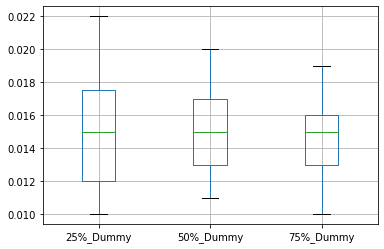

In [13]:
# Plot the box whisker plot for dummy approach prediction RMSE 
boxplot = df_dummy_rmse_summary.boxplot(column=['25%_Dummy', '50%_Dummy', '75%_Dummy'])

In [14]:
# Create a panda dataframe to store all the RMSE for the GP Regression experiments 
df_gp_rmse_summary = pd.DataFrame(columns=['25%_GP', '50%_GP','75%_GP'])

for engine_no in np.sort(df_all[0].unique()[:35]):
    
    #df_entry = pd.DataFrame(dict_summary[engine_no], columns = df_gp_rmse_summary.columns)
    df_gp_rmse_summary.loc[engine_no] = dict_summary[engine_no]



In [15]:
df_gp_rmse_summary

,25%_GP,50%_GP,75%_GP
1,0.034,0.030,0.035
2,0.014,0.017,0.019
3,0.023,0.018,0.030
4,0.013,0.016,0.025
5,0.017,0.016,0.018
6,0.022,0.025,0.031
7,0.020,0.017,0.022
8,0.022,0.021,0.038
9,0.016,0.014,0.023
10,0.010,0.011,0.013


In [16]:
# Save a copy of the result
df_gp_rmse_summary.to_excel(path+'25_Engines_GP_25_50_75_RMSE_Summary_2.xlsx')

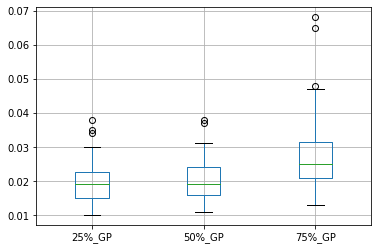

In [17]:
# Plot the box whisker plot for GP Regression prediction RMSE 
boxplot = df_gp_rmse_summary.boxplot(column=['25%_GP', '50%_GP', '75%_GP'])

### Experiment 2 --- Comparsion between Dummy Model and GP Regression

In [18]:
round(df_dummy_rmse_summary['75%_Dummy'].mean(),3)

0.015

In [19]:
# Create a numpy array to store the RMSE for dummy prediction
dummy_mean = np.array([round(df_dummy_rmse_summary['25%_Dummy'].mean(),3), \
                      round(df_dummy_rmse_summary['50%_Dummy'].mean(),3), \
                      round(df_dummy_rmse_summary['75%_Dummy'].mean(),3)])

# Create a numpy array to store the RMSE for GP Regression prediction
gpr_mean = np.array([round(df_gp_rmse_summary['25%_GP'].mean(),3), \
                    round(df_gp_rmse_summary['50%_GP'].mean(),3), \
                    round(df_gp_rmse_summary['75%_GP'].mean(),3)])


In [20]:
gpr_mean 

array([0.02 , 0.021, 0.029])

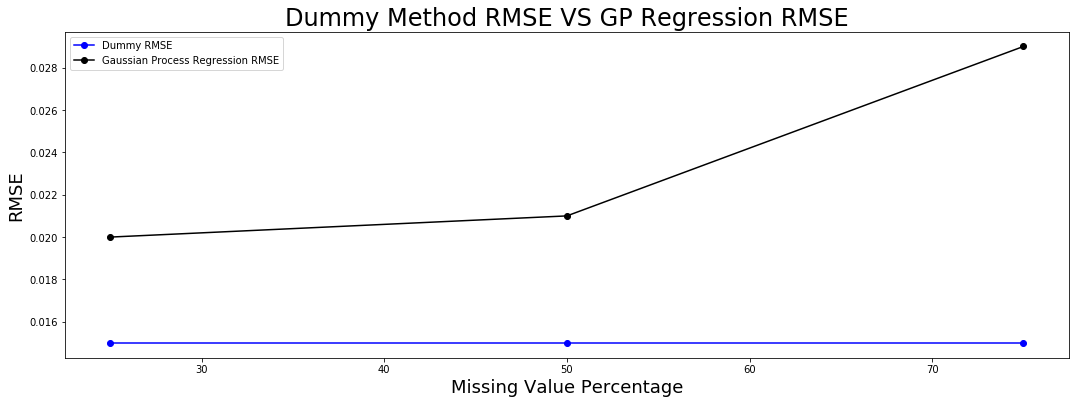

In [21]:
# Plot the RMSE for dummy prediction and GP Regression on the same plot
percent_error = [25,50,75]

plt.figure(figsize=(18,6))
plt.plot(percent_error,dummy_mean,'o-',color='blue',label='Dummy RMSE')

plt.plot(percent_error,gpr_mean,'o-',color='black',label='Gaussian Process Regression RMSE')

plt.xlabel('Missing Value Percentage',fontsize=18)
plt.ylabel('RMSE',fontsize=18)
plt.title('Dummy Method RMSE VS GP Regression RMSE',fontsize=24)

plt.legend()